## Query Sentinel-2 files from Element84

In [1]:
import satsearch

bbox = [35.48, -3.24, 35.58, -3.14] # (min lon, min lat, max lon, max lat)
dates = '2020-07-01/2020-08-15'

URL='https://earth-search.aws.element84.com/v0'
results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=dates,
                                  bbox=bbox,    
                                  sort=['<datetime'])

In [2]:
print('%s items' % results.found())
items = results.items()
# Save this locally for use later


18 items


In [3]:
features = items.geojson()["features"]
len(features)

18

In [8]:
dates = items.dates()
dates

[datetime.date(2020, 7, 2),
 datetime.date(2020, 7, 5),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 10),
 datetime.date(2020, 7, 12),
 datetime.date(2020, 7, 15),
 datetime.date(2020, 7, 17),
 datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 22),
 datetime.date(2020, 7, 25),
 datetime.date(2020, 7, 27),
 datetime.date(2020, 7, 30),
 datetime.date(2020, 8, 1),
 datetime.date(2020, 8, 4),
 datetime.date(2020, 8, 6),
 datetime.date(2020, 8, 9),
 datetime.date(2020, 8, 11),
 datetime.date(2020, 8, 14)]

In [5]:
from shapely.geometry import shape
from georeader.readers import S2_SAFE_reader

bands = ["B04", "B03", "B02"]
feature = features[0]
s2obj = S2_SAFE_reader.s2_load_from_fearure(feature,bands=bands)
s2obj

/home/gonzalo/miniconda3/envs/starcop/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 
         S2A_MSIL2A_20200814T074621_N0214_R135_T36MYB_20200814T103139.SAFE
         Transform: | 10.00, 0.00, 699960.00|
| 0.00,-10.00, 9700000.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (699960.0, 9590200.0, 809760.0, 9700000.0)
         CRS: EPSG:32736
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        

In [6]:
%%time
from georeader import read

data = read.read_from_bounds(s2obj, bbox,crs_bounds="EPSG:4326") # This does not trigger the download of the data
data_memory = data.load() # this triggers download only for the selected bands and within the bounds
data_memory

CPU times: user 298 ms, sys: 136 ms, total: 434 ms
Wall time: 10.8 s


 
         Transform: | 10.00, 0.00, 775600.00|
| 0.00,-10.00, 9652610.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 1110, 1115)
         Resolution: (10.0, 10.0)
         Bounds: (775600.0, 9641510.0, 786750.0, 9652610.0)
         CRS: EPSG:32736
         fill_value_default: 0
        

In [10]:
data.granules

{'overview': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/L2A_PVI.tif',
 'B11': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B11.tif',
 'B01': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B01.tif',
 'B12': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B12.tif',
 'B02': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B02.tif',
 'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B03.tif',
 'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif',
 'AOT': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2

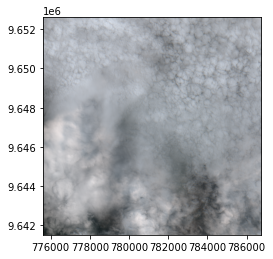

CPU times: user 515 ms, sys: 204 ms, total: 718 ms
Wall time: 526 ms


<AxesSubplot:>

In [7]:
%%time

import rasterio.plot as rstplt
import numpy as np

# From processing baseline PB04.00  values have an offset of 1_000
rstplt.show(np.clip(data_memory.values/10_000,0,1), transform=data_memory.transform)

18it [01:14,  4.17s/it]


CPU times: user 4.03 s, sys: 1.45 s, total: 5.48 s
Wall time: 1min 15s


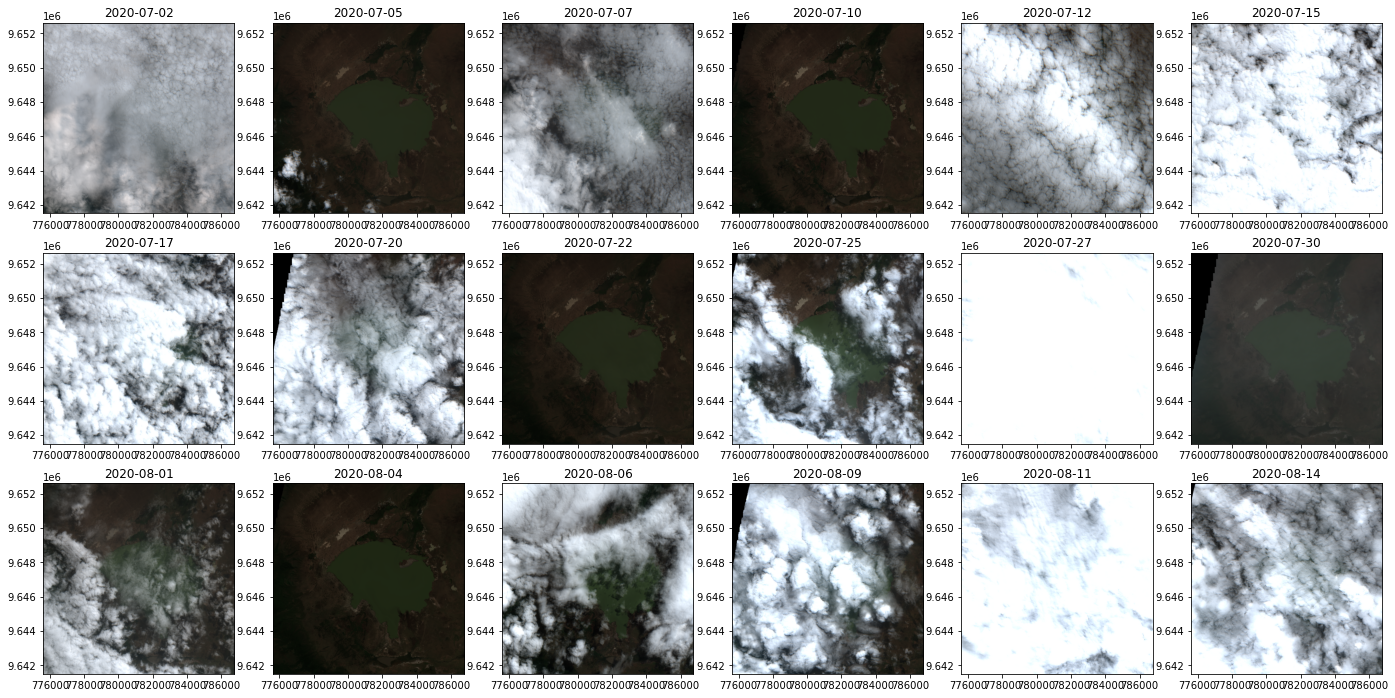

In [11]:
%%time

import matplotlib.pyplot as plt
from tqdm import tqdm

fig, ax = plt.subplots(3,6,figsize=(6*4,3*4))
ax = ax.flatten()

for _i, feature in tqdm(enumerate(features),total=len(features)):
    s2obj = S2_SAFE_reader.s2_load_from_fearure(feature,bands=bands)
    data_memory = read.read_from_bounds(s2obj, bbox,crs_bounds="EPSG:4326").load()
    rstplt.show(np.clip(data_memory.values/10_000,0,1), transform=data_memory.transform,ax=ax[_i])
    ax[_i].set_title(dates[_i])
    
    
    